In [1]:
%load_ext autoreload
%autoreload 2
language = "eng"

import sys
from copy import deepcopy
sys.path.insert(0, "../src/")
import os
import pandas as pd
get_ipython().run_line_magic("matplotlib", "inline")
import matplotlib.pyplot as plt
import time

from utils import get_labels
from cross_validation import Regression, TwoclassClassification, LibraryClassification, MulticlassClassification

features_dir = f"../data/features-2/{language}/" ##############################
results_dir = f"../data/results_sentiment/{language}/"
sentiment_labels_dir = "../data/labels_sentiment/"
canonization_labels_dir = "../data/labels_canon/"##############################3

if not os.path.exists(results_dir):
    os.makedirs(results_dir)

In [2]:
## Labels statistics
#print(len(pd.unique(labels["book_name"]))) #197
# 254 labels, 197 different book_names -> 57 second/third... reviews
# 36 book_names with more than 1 label, these 36 book_names have 93 labels
# 93 = 36 first reviews + 57 second/third... reviews
# 6 texts have opposing reviews (13 reviews are opposing)
# 191 texts after aggregating (without opposing reviews)

#labels["y"].plot.hist(grid=True, bins=50)

In [3]:
'''
Fehler
Brooke_Frances_Emily_Montague_1769
Lennox_Charlotte_The-Female_Quixote_1752
Stoker_Bram-Dracula_1897

Nicolai_Friedrich_Sebaldus-Nothanker-1773
Jung-Stilling_Heinrich-Stillings-Jugend_1777
Sacher-Masoch_Venus-im-Pelz_1869
Hunold_Christian_Friedrich_Die-liebenswuerdige-Adalie_1681

Hoffmansthal_Hugo ['Hoffmansthal_Hugo_Andreas-oder-die-Vereinigten_1907', 'Hoffmansthal_Hugo_Das-Maerchen-der-672-Nacht_1895'] 
Hoffmansthal_Hugo-von ['Hoffmansthal_Hugo-von_Ein-Brief_1902', 'Hoffmansthal_Hugo-von_Reitergeschichte_1899'] 


Anonymous anonymous

df = df.loc[df["book_name"] != "Defoe_Daniel_Roxana_1724"]

'''

'\nFehler\nBrooke_Frances_Emily_Montague_1769\nLennox_Charlotte_The-Female_Quixote_1752\nStoker_Bram-Dracula_1897\n\nNicolai_Friedrich_Sebaldus-Nothanker-1773\nJung-Stilling_Heinrich-Stillings-Jugend_1777\nSacher-Masoch_Venus-im-Pelz_1869\nHunold_Christian_Friedrich_Die-liebenswuerdige-Adalie_1681\n\nHoffmansthal_Hugo [\'Hoffmansthal_Hugo_Andreas-oder-die-Vereinigten_1907\', \'Hoffmansthal_Hugo_Das-Maerchen-der-672-Nacht_1895\'] \nHoffmansthal_Hugo-von [\'Hoffmansthal_Hugo-von_Ein-Brief_1902\', \'Hoffmansthal_Hugo-von_Reitergeschichte_1899\'] \n\n\nAnonymous anonymous\n\ndf = df.loc[df["book_name"] != "Defoe_Daniel_Roxana_1724"]\n\n'

In [4]:
'''
Parameter combinations
'''

textblob_labels = get_labels(language, sentiment_labels_dir, canonization_labels_dir, 'textblob')
sentiart_labels = get_labels(language, sentiment_labels_dir, canonization_labels_dir, 'sentiart')
combined_labels = get_labels(language, sentiment_labels_dir, canonization_labels_dir, 'combined')
classification_labels = get_labels(language, sentiment_labels_dir, canonization_labels_dir, 'classification')
library_labels = get_labels(language, sentiment_labels_dir, canonization_labels_dir, 'library')
           
book_df = pd.read_csv(f"{features_dir}book_df.csv")
book_and_averaged_chunk_df = pd.read_csv(f"{features_dir}book_and_averaged_chunk_df.csv")
chunk_df = pd.read_csv(f"{features_dir}chunk_df.csv")
chunk_and_copied_book_df = pd.read_csv(f"{features_dir}chunk_and_copied_book_df.csv")

#Remove duplicate text
book_df = book_df.loc[book_df["book_name"] != "Defoe_Daniel_Roxana_1724"] ########################################
book_and_averaged_chunk_df = book_and_averaged_chunk_df.loc[book_and_averaged_chunk_df["book_name"] != "Defoe_Daniel_Roxana_1724"]
chunk_df = chunk_df.loc[chunk_df["book_name"] != "Defoe_Daniel_Roxana_1724"]
chunk_and_copied_book_df = chunk_and_copied_book_df.loc[chunk_and_copied_book_df["book_name"] != "Defoe_Daniel_Roxana_1724"]

In [5]:
# All parameters
languages_list = ["eng", "ger"]
models_list = ["svr", "lasso", "xgboost", "svc"]
model_params_dict = {"svr": [1], "lasso": [1, 4], "xgboost": [None], "svc": [0.1, 1, 10, 100, 1000, 10000]} 
dimensionality_reduction_list = ["ss_pca_0_95", 'k_best_f_reg_0_10', 'k_best_mutual_info_0_10', None]
features_list = ["book", "chunk", "baac", "cacb"]
features_dict = {"book": book_df, "chunk": chunk_df, "baac": book_and_averaged_chunk_df, 
                 "cacb": chunk_and_copied_book_df}
labels_list = ['textblob', 'sentiart', 'combined', 'classification', 'library']
labels_dict = {'textblob': textblob_labels, 'sentiart': sentiart_labels, 'combined': combined_labels, 
          'classification': classification_labels, 'library': library_labels}
drop_columns_list = [
    ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding"],
    ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "pos"],
    ]
if language == "eng":
    drop_columns_list.extend([
        ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "->"], 
        ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "->", "pos"]
    ])
    
# Model-specific column names for writing results to file
general_cols = ['language', 'target', 'model', 'model_param', 'labels_string', 'features_string',
    'dimensionality_reduction', 'drop_columns']
regression_cols = general_cols + ["mean_train_mse", "mean_train_rmse", "mean_train_mae", "mean_train_r2", 
    "mean_train_corr", "mean_validation_mse", "mean_validation_rmse", "mean_validation_mae", 
    "mean_validation_r2", "mean_validation_corr", "mean_p_value"]
twoclass_cols = general_cols + ["mean_train_book_acc", "mean_validation_book_acc"] # also used for library
multiclass_cols = general_cols + ["mean_train_f1", "mean_validation_f1"]


# Link parameters to models
regression_dict = {
    "model": ["xgboost"], 
    "dimensionality_reduction": [None], 
    "features": features_list,
    "labels": ['textblob', 'sentiart', 'combined'],
    "drop_columns": drop_columns_list,
    "model_cols": regression_cols}
library_dict = {
    "model": ["svc", "xgboost"], 
    "dimensionality_reduction": [None], 
    "features": ["book", "baac"],
    "labels": ['library'],
    "drop_columns": drop_columns_list,
    "model_cols": twoclass_cols}
twoclass_dict = {
    "model": ["svc", "xgboost"], 
    "dimensionality_reduction": [None], 
    "features": ["book", "baac"],
    "labels": ['classification'],
    "drop_columns": drop_columns_list,
    "model_cols": twoclass_cols}
multiclass_dict = {
    "model": ["svc", "xgboost"], 
    "dimensionality_reduction": [None],
    "features": ["book", "baac"],
    "labels": ['classification'],
    "drop_columns": drop_columns_list,
    "model_cols": multiclass_cols}
testing_dict = {
    "model": ["xgboost"], 
    "dimensionality_reduction": [None], 
    "features": ["baac", "cacb"],
    "labels": ['sentiart', "combined"],
    "drop_columns": [drop_columns_list[-1]],
    "model_cols": regression_cols}

In [6]:
'''
Run Cross-Validation
'''  
target = "testing" 
if target == "regression":
    param_dict = regression_dict
elif target == "library":
    param_dict = library_dict
elif target == "twoclass":
    param_dict = twoclass_dict
elif target == "multiclass":
    param_dict = multiclass_dict
elif target == "testing":
    param_dict = testing_dict

In [7]:
start = time.time()

eng testing xgboost None sentiart baac None ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->', 'pos']
Dropped 0 columns.
                                             book_name         y
0             Ainsworth_William-Harrison_Rookwood_1834 -0.097343
1    Anonymous_Anonymous_The-Adventures-of-Anthony-...  0.002943
3                 Austen_Jane_Pride-and-Prejudice_1813  0.045825
4               Austen_Jane_Sense-and-Sensibility_1811  0.030519
5              Ballantyne_Robert_The-Coral-Island_1858 -0.031421
..                                                 ...       ...
248                  Wells_H-G_The-World-Set-Free_1914  0.010914
249                         Wells_H-G_Tono-Bungay_1909  0.006893
250        Wilde_Oscar_The-Picture-of-Dorian-Gray_1890  0.007171
251                      Wollstonecraft_Mary_Mary_1788 -0.007740
253               Yonge_Charlotte_The-Daisy-Chain_1856 -0.007486

[197 rows x 2 columns]
                                          

train preds: [-9.57784727e-02  1.89459743e-03  4.42416519e-02  3.14372145e-02
 -3.10009513e-02 -3.87379937e-02 -6.87131798e-03  1.00631104e-03
 -3.25967483e-02  1.23547185e-02 -6.08970760e-04 -2.11386550e-02
  4.57293075e-03 -2.77429670e-02 -3.60366106e-02 -5.17316116e-03
 -2.34115906e-02 -2.93190815e-02 -5.71490973e-02 -1.39271365e-02
  1.35553721e-02  5.92679530e-03  9.27627552e-03  3.81243601e-02
 -3.41597721e-02  6.67214114e-03 -9.82268825e-02 -6.87746331e-03
 -1.38981286e-02  2.39925869e-02  5.75625384e-03 -4.32998911e-02
  2.50032712e-02 -1.12471292e-02  1.64987948e-02 -2.77034882e-02
 -1.56042064e-02 -5.46650589e-02  4.14407067e-03 -3.62185687e-02
  2.89806654e-03 -1.23868082e-02 -2.09236741e-02 -1.89684723e-02
  2.21865121e-02 -9.60376859e-03  7.69854151e-03 -1.15691992e-02
  3.76847852e-03 -2.66290940e-02  2.63233203e-03  2.28241226e-03
  2.22506151e-02 -4.00007702e-04 -7.65288249e-02 -1.13316104e-02
  2.59007048e-03  4.11462709e-02  9.66322049e-03  6.09986077e-04
 -1.70422643

train preds: [-0.07673863  0.00216849  0.03693406  0.02997183 -0.01853204 -0.03941968
 -0.00604181 -0.00930123 -0.02479871 -0.00956234  0.00627498 -0.01295725
 -0.02111548  0.00170685 -0.02244257 -0.02461861 -0.01101094 -0.01713417
 -0.02525317 -0.02809083  0.00387857  0.00238259 -0.04773462 -0.0005614
 -0.03218297  0.00308926 -0.04414925 -0.01907789 -0.07313653 -0.00414927
 -0.01852212  0.01462702 -0.02074157  0.01297311 -0.00951389  0.00438617
 -0.02296306 -0.01556802 -0.050082   -0.00281486 -0.03188637 -0.00543663
 -0.01289252 -0.0085308  -0.01849304  0.01446808 -0.01579569 -0.00503897
 -0.00431244 -0.00665616 -0.01386093 -0.00377714 -0.00377714  0.00907321
  0.00183433 -0.04222177 -0.01002944 -0.0085953   0.03411808  0.01017116
 -0.0007013   0.00020243  0.00553321 -0.00801073  0.01242696 -0.01735072
 -0.02344829  0.00082999 -0.00713096 -0.01535023 -0.05115489 -0.00497924
 -0.00316352 -0.00237521 -0.01407752 -0.016732   -0.00711212  0.00038203
 -0.01688521 -0.01014961  0.00695255  0

train preds: [-9.6870884e-02  2.2559124e-03  4.5087434e-02  3.0547371e-02
 -3.0966790e-02 -3.9347060e-02 -7.0927278e-03 -2.1867074e-04
 -3.2330330e-02 -1.7435968e-02  1.2387443e-02 -6.1740284e-04
 -3.5652142e-02 -2.3420451e-02 -3.0819740e-02 -4.0777799e-02
  2.3637549e-03 -5.6769375e-02 -1.4672761e-02 -5.5390712e-02
  5.4845102e-03  9.0306373e-03  3.8420562e-02 -5.9014585e-02
 -2.3197692e-02 -9.7840704e-02 -6.9309841e-03 -1.3920898e-02
  2.3245806e-02  6.7493264e-03 -4.3284185e-02  2.4654383e-02
 -1.1067695e-02  1.6878402e-02 -2.7818780e-02 -1.5115943e-02
 -5.6206044e-02  4.6495502e-03 -3.6780205e-02 -1.2415936e-02
 -2.1903025e-02 -1.8466953e-02  2.2349296e-02 -1.0188881e-02
  9.3172602e-03 -1.2773540e-02  4.4302018e-03 -2.6370730e-02
  2.9687954e-03  2.2377872e-03  2.2722604e-02 -4.8445014e-04
 -7.6962754e-02 -1.0747337e-02  2.5702014e-03  4.2627066e-02
  9.4224066e-03 -2.5812385e-04  2.0954250e-03  2.7516512e-03
 -1.7131208e-02  6.4641228e-03 -4.7169771e-02 -2.5858335e-02
  8.6159055

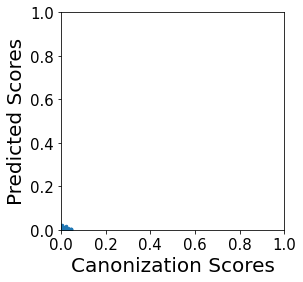

all columns ['eng', 'testing', 'xgboost', None, 'sentiart', 'baac', None, ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->', 'pos'], 0.0, 0.005, 0.004, 0.923, 0.975, 0.001, 0.029, 0.022, -0.395, 0.073, 0.467]
eng testing xgboost None sentiart baac None ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->', 'pos'] [0.0, 0.005, 0.004, 0.923, 0.975, 0.001, 0.029, 0.022, -0.395, 0.073, 0.467]

-----------------------------------------------------------

eng testing xgboost None sentiart cacb None ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->', 'pos']
Dropped 0 columns.
                                             book_name         y
0             Ainsworth_William-Harrison_Rookwood_1834 -0.097343
1    Anonymous_Anonymous_The-Adventures-of-Anthony-...  0.002943
3                 Austen_Jane_Pride-and-Prejudice_1813  0.045825
4               Austen_Jane_Sense-and-Sensibility_1811  0.030519
5    

train preds: [-0.09720213 -0.09720213 -0.09720213 ... -0.00735593 -0.00756787
 -0.00735593]
validation preds: [-0.04407131 -0.04407131 -0.04407131 -0.0440002  -0.04407131 -0.0440002
 -0.04394108 -0.04357725 -0.04407131 -0.04399467 -0.04407131 -0.04407131
 -0.04407131 -0.04407131 -0.04407131 -0.04407131 -0.04404046 -0.04407131
 -0.00645331 -0.00645331 -0.00645331 -0.00645331 -0.00645331 -0.00645331
 -0.00645331 -0.00645331 -0.00645331 -0.00645331 -0.00645331 -0.00645331
 -0.00645331 -0.00645331 -0.00645331 -0.00645331 -0.00645331 -0.00645331
 -0.00645331 -0.00645331 -0.00645331 -0.00645331 -0.00645331 -0.00645331
 -0.00645331 -0.00645331 -0.0236497  -0.0236497  -0.0236497  -0.0236497
 -0.0236497  -0.0236497  -0.0236497  -0.0236497  -0.0236497  -0.0236497
 -0.0236497  -0.0236497  -0.0236497  -0.0236497  -0.0236497  -0.0236497
 -0.0236497  -0.0236497  -0.0236497  -0.0236497  -0.0236497  -0.0236497
 -0.0236497  -0.0236497  -0.0236497  -0.0236497  -0.0236497  -0.0236497
 -0.0236497  -0.0236

train preds: [-0.09722676 -0.09722676 -0.09722676 ... -0.00754832 -0.00754832
 -0.00754832]
validation preds: [ 0.00935351  0.00935351  0.00942404  0.00927572  0.00942404  0.00935351
 -0.00538994 -0.00538994 -0.00577956 -0.00567816 -0.00588826 -0.00549134
 -0.00549134 -0.00549134 -0.00538994 -0.00538994 -0.00549134  0.00568582
  0.00594171 -0.01965796 -0.01965796 -0.01936974 -0.01965796 -0.01936974
 -0.01936974 -0.01965796 -0.01936974 -0.01936974 -0.01965796 -0.01965796
 -0.01965796 -0.01936974 -0.01965796 -0.01936974 -0.01936974 -0.01936974
 -0.01965796 -0.01965796 -0.01936974 -0.01965796 -0.01965796 -0.01965796
 -0.01936974 -0.01965796 -0.02228979 -0.02228979 -0.02228979 -0.02228979
 -0.02228979 -0.02228979 -0.02228979 -0.02228979 -0.02228979 -0.02228979
 -0.02228979 -0.02228979 -0.02228979 -0.02228979 -0.02228979 -0.02228979
 -0.02228979 -0.02228979 -0.02228979 -0.02228979 -0.02228979 -0.02228979
 -0.02228979 -0.02228979 -0.02228979 -0.02228979 -0.02228979 -0.02228979
 -0.02228979 -

train preds: [-0.09732007 -0.09716488 -0.09732007 ... -0.00748403 -0.00748403
 -0.00748403]
validation preds: [ 0.00935588  0.00935588  0.00935588  0.00935588  0.00935588  0.00935588
  0.00935588  0.00935588  0.00935588  0.00935588  0.00935588  0.00935588
  0.00935588  0.00935588  0.00935588  0.00935588  0.00935588  0.00935588
  0.00935588  0.00935588  0.00935588  0.00935588  0.00935588  0.00935588
  0.00935588  0.00935588  0.00935588  0.00935588  0.00935588  0.00935588
  0.00935588  0.00935588  0.00935588  0.00935588  0.00935588  0.00935588
  0.00935588  0.00935588  0.00935588  0.00935588  0.00935588  0.00935588
  0.00935588  0.00935588  0.00935588  0.00935588  0.00935588  0.00935588
  0.00935588  0.00935588  0.00935588  0.00935588  0.00935588  0.00935588
  0.00935588  0.00935588  0.00935588  0.00935588  0.00935588  0.00935588
  0.00935588  0.00935588  0.00935588  0.00935588  0.00935588  0.00935588
  0.00935588  0.00935588  0.00935588 -0.00468898 -0.00468898 -0.00468898
 -0.00468898 -

train preds: [-0.06994729 -0.06994729 -0.06994729 ... -0.009621   -0.009621
 -0.009621  ]
validation preds: [-0.01103954 -0.01103954 -0.01103954 -0.01103954 -0.01103954 -0.01103954
 -0.01103954 -0.01103954 -0.01103954 -0.01103954 -0.01103954 -0.01103954
 -0.01103954 -0.01103954 -0.01103954 -0.01103954 -0.01103954 -0.01103954
 -0.01103954 -0.01103954 -0.01103954 -0.01103954 -0.01103954 -0.01103954
 -0.01103954 -0.01103954 -0.01103954 -0.01103954 -0.01103954 -0.01312482
 -0.01312482 -0.01312482 -0.01312482 -0.01312482 -0.01312482 -0.01312482
 -0.01312482 -0.01312482 -0.01312482 -0.01312482 -0.01312482 -0.01312482
 -0.01312482 -0.01312482 -0.01312482 -0.01312482 -0.01312482 -0.01312482
 -0.01312482 -0.01312482 -0.01312482 -0.01312482 -0.01312482 -0.01312482
  0.00424596  0.00424596  0.00424596  0.00424596  0.00424596  0.00424596
  0.00424596 -0.00242795 -0.00242795 -0.00242795 -0.00242795 -0.00242795
 -0.00242795 -0.00242795 -0.00242795 -0.00242795 -0.00242795 -0.002741
 -0.002741   -0.00

train preds: [-0.09704539 -0.09704539 -0.09704539 ... -0.00756921 -0.00756921
 -0.00756921]
validation preds: [0.00140859 0.00140859 0.00140859 ... 0.00379507 0.00379507 0.00379507]
Fold: 8, TrainMSE: 0.0, TrainMAE: 0.0, ValMSE: 0.001, ValMAE: 0.023, ValR2: -0.325, ValCorr: 0.083
train preds: [-0.09742942 -0.09685551 -0.09742942 ... -0.00741792 -0.00752987
 -0.00741792]
validation preds: [-0.01270837 -0.01239369 -0.01270837 -0.01297629 -0.01267454 -0.01292551
 -0.01319883 -0.01240123 -0.0129268  -0.01240123 -0.01284017 -0.01231588
 -0.01319883 -0.01297629 -0.01248583 -0.01236115 -0.01319129 -0.01270837
 -0.01248583 -0.0129268  -0.01887349 -0.01885863 -0.01884264 -0.01815045
 -0.01815045 -0.01884264 -0.01885863 -0.01885863 -0.01884264 -0.01884264
 -0.01885863 -0.01885863 -0.01885863 -0.01884264 -0.01885863 -0.01885863
 -0.01884264 -0.01884264 -0.01885863 -0.01884264 -0.01884264 -0.01887349
 -0.01884264 -0.01885863 -0.01885863 -0.01884264 -0.01885863 -0.01885863
 -0.01885863 -0.01884264 

train preds: [-0.09725245 -0.09725245 -0.09725245 ... -0.00749425 -0.00749425
 -0.00749425]
validation preds: [-0.01065329 -0.01065329 -0.01108677 -0.01108677 -0.01108677 -0.0106776
 -0.0106776  -0.0106776  -0.0106776  -0.0106776  -0.0106776  -0.0106776
 -0.0106776  -0.0106776  -0.0106776  -0.0106776  -0.0106776  -0.01112303
 -0.01042155 -0.01112303 -0.01042155 -0.01112303 -0.01112303 -0.01118956
 -0.01112303 -0.01112303 -0.01112303  0.00114429  0.00114429  0.00114429
  0.00114429  0.00114429  0.00114429  0.00114429  0.00114429  0.0011173
  0.00114429  0.00114429  0.00114429  0.0011173   0.00114429  0.00114429
  0.00114429  0.0011173   0.00114429  0.00114429  0.00114429  0.00114429
  0.0011173   0.00114429  0.00114429  0.00114429  0.00114429  0.0011173
  0.00114429 -0.00528409 -0.00528409 -0.00528409 -0.00528409 -0.00528409
 -0.00528409 -0.00528409 -0.00528409 -0.00528409 -0.00528409 -0.00528409
 -0.00528409 -0.00528409 -0.00528409 -0.00528409 -0.00528409 -0.00528409
 -0.00528409 -0.00

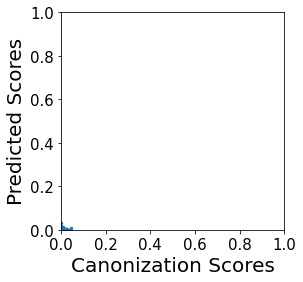

all columns ['eng', 'testing', 'xgboost', None, 'sentiart', 'cacb', None, ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->', 'pos'], 0.0, 0.003, 0.003, 0.922, 0.965, 0.001, 0.029, 0.022, -0.305, 0.018, 0.471]
eng testing xgboost None sentiart cacb None ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->', 'pos'] [0.0, 0.003, 0.003, 0.922, 0.965, 0.001, 0.029, 0.022, -0.305, 0.018, 0.471]

-----------------------------------------------------------

eng testing xgboost None combined baac None ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->', 'pos']
Dropped 0 columns.
                                             book_name         y
0             Ainsworth_William-Harrison_Rookwood_1834 -0.097343
1    Anonymous_Anonymous_The-Adventures-of-Anthony-... -0.004102
3                 Austen_Jane_Pride-and-Prejudice_1813  0.029731
4               Austen_Jane_Sense-and-Sensibility_1811  0.049103
5    

train preds: [-0.04079633 -0.00488667  0.02578695  0.02967232  0.02139032  0.00806264
  0.02423002  0.00377091  0.0038812  -0.00849306  0.00517122  0.01378762
 -0.00791083 -0.01041163  0.00773662  0.0158601  -0.01499718  0.02613991
  0.02140979 -0.01634746  0.0419527   0.01478477  0.02802164 -0.00969725
  0.04485562 -0.00728745 -0.00356518 -0.06380834  0.04276475  0.02180767
 -0.00163824  0.01646839  0.01188601  0.01918725  0.01945676  0.03590387
  0.01138557  0.01197999  0.01273845  0.01689743  0.00636035  0.02955013
  0.01915566  0.01413591  0.00766287  0.03162897  0.03232975  0.01642881
  0.01761388  0.01160472  0.0115752   0.02140483  0.01293342  0.01194474
  0.03030331  0.00858892  0.00686313  0.01989244  0.03092727  0.01916246
  0.0312138   0.02931897  0.02469699  0.02048489  0.02335171  0.02067553
  0.01575728  0.03246465 -0.00414361  0.01519939 -0.00392978  0.01200485
  0.01322405  0.01138614  0.00601579  0.02863229  0.02857218  0.01709381
  0.00465411  0.02516164  0.03693438  

train preds: [-0.09041535 -0.0030446   0.03000881  0.04883537  0.02621187  0.00992106
  0.01630242  0.03774429 -0.00740338  0.00707287  0.05320963  0.04132839
  0.0065576   0.01934578 -0.00605687 -0.02962909  0.0248472  -0.02071895
 -0.02930805 -0.01226909  0.02302567  0.02511633 -0.01901873  0.07391623
 -0.0063265   0.06598159 -0.0540561   0.00081936 -0.08988945  0.06240528
  0.0399094   0.00047233 -0.01184384  0.01754188  0.0297458   0.04884544
  0.00155722  0.01582773  0.00121536  0.03848306 -0.00534259  0.05968903
  0.04189484  0.00877915  0.00998435  0.05073234  0.04487527  0.05081137
  0.01659568  0.01847315  0.00047833  0.03834048  0.00782861  0.01272642
  0.03844757 -0.01986923  0.01101635  0.03760396  0.0429055   0.02058705
  0.09378427  0.03396136  0.02364898  0.00896243  0.01889041 -0.0001992
  0.00714302  0.04789975 -0.02464793  0.01046764 -0.01286375  0.01376046
  0.00189912  0.00957432 -0.00281441  0.01109432  0.06641418  0.02526351
 -0.02593755  0.02788571  0.07017326  0

train preds: [-0.07384566 -0.000211    0.02686889  0.03376434  0.02447473  0.01347221
  0.01715805  0.03279066 -0.00929459  0.00698084  0.03468196  0.01201551
  0.01638734 -0.00540092  0.02243884 -0.01292859 -0.02256122 -0.00555303
  0.01778155 -0.01852183  0.04502039  0.01959442 -0.01538139  0.06817464
  0.01811782  0.03459065 -0.00484113  0.06203656 -0.04888294  0.00080459
 -0.07217628  0.0525875   0.03382863  0.01268091  0.02849069  0.00140034
  0.02063776  0.02586182  0.0402036   0.005605    0.02029644  0.00270534
  0.02786431  0.00181769  0.04023321  0.01748125  0.01137779  0.04598599
  0.03796726  0.03871465  0.01761168  0.01604607  0.00369279  0.02598858
  0.01212679  0.03143246  0.02487314  0.01905769  0.01983965  0.01010973
  0.01191071  0.03801139 -0.01437383  0.01801335 -0.01115486  0.01425551
  0.00396825  0.01479265  0.00027809  0.01530273  0.05171813  0.01704744
 -0.01924702  0.02834217  0.05450492  0.05278122 -0.02639131  0.02314131
  0.01188129  0.02089855 -0.02088261  

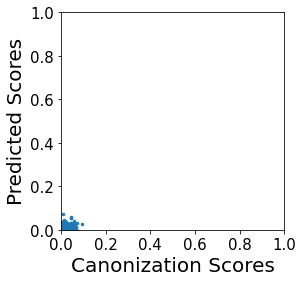

all columns ['eng', 'testing', 'xgboost', None, 'combined', 'baac', None, ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->', 'pos'], 0.0, 0.011, 0.008, 0.832, 0.944, 0.001, 0.032, 0.025, -0.34, 0.152, 0.018]
eng testing xgboost None combined baac None ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->', 'pos'] [0.0, 0.011, 0.008, 0.832, 0.944, 0.001, 0.032, 0.025, -0.34, 0.152, 0.018]

-----------------------------------------------------------

eng testing xgboost None combined cacb None ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->', 'pos']
Dropped 0 columns.
                                             book_name         y
0             Ainsworth_William-Harrison_Rookwood_1834 -0.097343
1    Anonymous_Anonymous_The-Adventures-of-Anthony-... -0.004102
3                 Austen_Jane_Pride-and-Prejudice_1813  0.029731
4               Austen_Jane_Sense-and-Sensibility_1811  0.049103
5      

train preds: [-0.06970236 -0.06970236 -0.06970236 ...  0.02065029  0.02065029
  0.02065029]
validation preds: [-0.00167711 -0.00167711 -0.00167711 -0.00167711 -0.00167711 -0.00167711
 -0.00167711 -0.00167711 -0.00167711 -0.00167711 -0.00167711 -0.00167711
 -0.00167711 -0.00167711 -0.00167711 -0.00167711 -0.00167711 -0.00167711
  0.01486142  0.01486142  0.01486142  0.01486142  0.01486142  0.01486142
  0.01486142  0.01486142  0.01486142  0.01486142  0.01486142  0.01486142
  0.01486142  0.01486142  0.01486142  0.01486142  0.01486142  0.01486142
  0.01486142  0.01486142  0.01486142  0.01486142  0.01486142  0.01486142
  0.01486142  0.01486142 -0.00985803 -0.00985803 -0.00985803 -0.00985803
 -0.00985803 -0.00985803 -0.00985803 -0.00985803 -0.00985803 -0.00985803
 -0.00985803 -0.00985803 -0.00985803 -0.00985803 -0.00985803 -0.00985803
 -0.00985803 -0.00985803 -0.00985803 -0.00985803 -0.00985803 -0.00985803
 -0.00985803 -0.00985803 -0.00985803 -0.00985803 -0.00985803 -0.00985803
 -0.00985803 -

train preds: [-0.07951925 -0.07951925 -0.07951925 ...  0.02230986  0.02230986
  0.02230986]
validation preds: [ 0.04200567  0.04200567  0.04200567  0.04200567  0.04200567  0.04200567
  0.0208473   0.0208473   0.0208473   0.0208473   0.0208473   0.0208473
  0.0208473   0.0208473   0.0208473   0.0208473   0.0208473   0.01144041
  0.01144041 -0.00733255 -0.00733255 -0.00733255 -0.00733255 -0.00733255
 -0.00733255 -0.00733255 -0.00733255 -0.00733255 -0.00733255 -0.00733255
 -0.00733255 -0.00733255 -0.00733255 -0.00733255 -0.00733255 -0.00733255
 -0.00733255 -0.00733255 -0.00733255 -0.00733255 -0.00733255 -0.00733255
 -0.00733255 -0.00733255  0.02724947  0.02724947  0.02724947  0.02724947
  0.02724947  0.02724947  0.02724947  0.02724947  0.02724947  0.02724947
  0.02724947  0.02724947  0.02724947  0.02724947  0.02724947  0.02724947
  0.02724947  0.02724947  0.02724947  0.02724947  0.02724947  0.02724947
  0.02724947  0.02724947  0.02724947  0.02724947  0.02724947  0.02724947
  0.02724947  0

train preds: [-0.0696478  -0.0696478  -0.0696478  ...  0.02056015  0.02056015
  0.02056015]
validation preds: [ 0.02312405  0.02312405  0.02312405  0.02312405  0.02312405  0.02312405
  0.02312405  0.02312405  0.02312405  0.02312405  0.02312405  0.02312405
  0.02312405  0.02312405  0.02312405  0.02312405  0.02312405  0.02312405
  0.02312405  0.02312405  0.02312405  0.02312405  0.02312405  0.02312405
  0.02312405  0.02312405  0.02312405  0.02312405  0.02312405  0.02312405
  0.02312405  0.02312405  0.02312405  0.02312405  0.02312405  0.02312405
  0.02312405  0.02312405  0.02312405  0.02312405  0.02312405  0.02312405
  0.02312405  0.02312405  0.02312405  0.02312405  0.02312405  0.02312405
  0.02312405  0.02312405  0.02312405  0.02312405  0.02312405  0.02312405
  0.02312405  0.02312405  0.02312405  0.02312405  0.02312405  0.02312405
  0.02312405  0.02312405  0.02312405  0.02312405  0.02312405  0.02312405
  0.02312405  0.02312405  0.02312405  0.02264758  0.02264758  0.02264758
  0.02264758  

train preds: [-0.09247796 -0.07249714 -0.09247796 ...  0.02813971  0.02813971
  0.02813971]
validation preds: [ 0.01912927  0.01912927  0.01912927  0.01912927  0.01912927  0.01912927
  0.01912927  0.01912927  0.01912927  0.01912927  0.01912927  0.01912927
  0.01912927  0.01912927  0.01912927  0.01912927  0.01912927  0.01912927
  0.01912927  0.01912927  0.01912927  0.01912927  0.01912927  0.01912927
  0.01912927  0.01912927  0.01912927  0.01912927  0.01912927  0.0147869
  0.0147869   0.0147869   0.0147869   0.0147869   0.0147869   0.0147869
  0.0147869   0.0147869   0.0147869   0.0147869   0.0147869   0.0147869
  0.0147869   0.0147869   0.0147869   0.0147869   0.0147869   0.0147869
  0.0147869   0.0147869   0.0147869   0.0147869   0.0147869   0.0147869
 -0.031955   -0.031955   -0.031955   -0.031955   -0.031955   -0.031955
 -0.031955    0.01928661  0.01928661  0.01928661  0.01928661  0.01928661
  0.01928661  0.01928661  0.01928661  0.01928661  0.01928661  0.00069512
  0.00069512  0.00069

train preds: [-0.09418423 -0.09418423 -0.09418423 ...  0.02760847  0.02760847
  0.02760847]
validation preds: [0.01803111 0.01803111 0.01803111 ... 0.0493907  0.0493907  0.0493907 ]
Fold: 8, TrainMSE: 0.0, TrainMAE: 0.003, ValMSE: 0.001, ValMAE: 0.026, ValR2: -0.243, ValCorr: 0.158
train preds: [-0.09646471 -0.09646471 -0.09646471 ...  0.02712915  0.02712915
  0.02712915]
validation preds: [ 0.02608936  0.02608936  0.02608936  0.02608936  0.02608936  0.02608936
  0.02608936  0.02608936  0.02608936  0.02608936  0.02608936  0.02608936
  0.02608936  0.02608936  0.02608936  0.02608936  0.02608936  0.02608936
  0.02608936  0.02608936  0.01709392  0.01709392  0.01709392  0.01709392
  0.01709392  0.01709392  0.01709392  0.01709392  0.01709392  0.01709392
  0.01709392  0.01709392  0.01709392  0.01709392  0.01709392  0.01709392
  0.01709392  0.01709392  0.01709392  0.01709392  0.01709392  0.01709392
  0.01709392  0.01709392  0.01709392  0.01709392  0.01709392  0.01709392
  0.01709392  0.0170939

train preds: [-0.09729841 -0.0971963  -0.09746252 ...  0.02726708  0.02727433
  0.02727433]
validation preds: [ 0.00185308  0.00165316  0.00185308  0.00165316  0.00185308  0.01010933
  0.01010933  0.01010933  0.0104752   0.0104752   0.0104752   0.00916317
  0.0104752   0.0104752   0.01010933  0.01006821  0.00952905  0.03228865
  0.03124975  0.03124975  0.03256788  0.03097051  0.03127507  0.03127507
  0.03228865  0.03228865  0.03228865  0.02646221  0.02650333  0.02685966
  0.02650333  0.02650333  0.02646221  0.02650333  0.02650333  0.02650333
  0.02650333  0.02650333  0.02646221  0.02650333  0.02646221  0.02646221
  0.02646221  0.02646221  0.02646221  0.02646221  0.02650333  0.02646221
  0.02650333  0.02650333  0.02724083  0.02650333  0.02724083  0.02685966
  0.02763828  0.04205976  0.04196487  0.04034835  0.04218177  0.04196487
  0.04196487  0.04196487  0.04218177  0.04205976  0.04196487  0.04205976
  0.04227666  0.04196487  0.04205976  0.04025346  0.04205976  0.04227666
  0.04218177  

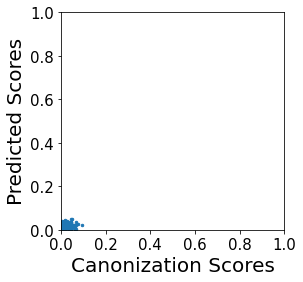

all columns ['eng', 'testing', 'xgboost', None, 'combined', 'cacb', None, ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->', 'pos'], 0.0, 0.008, 0.006, 0.871, 0.949, 0.001, 0.032, 0.025, -0.241, 0.192, 0.031]
eng testing xgboost None combined cacb None ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->', 'pos'] [0.0, 0.008, 0.006, 0.871, 0.949, 0.001, 0.032, 0.025, -0.241, 0.192, 0.031]

-----------------------------------------------------------



In [8]:
results = []
with open(f"{results_dir}results-{language}-{target}-log.csv", 'w') as f:
    f.write("\t".join(testing_dict['model_cols']) + '\n')
    for model in param_dict['model']:
        model_param = model_params_dict[model]
        for model_param in model_param:
            for labels_string in param_dict['labels']:
                labels = deepcopy(labels_dict[labels_string])
                for features_string in param_dict["features"]:
                    df = deepcopy(features_dict[features_string])
                    for dimensionality_reduction in param_dict["dimensionality_reduction"]:
                        for drop_columns in param_dict["drop_columns"]:
                            print(language, target, model, model_param, labels_string, features_string,
                                dimensionality_reduction, drop_columns)

                            if target == 'regression' or 'testing':#¼################3
                                experiment = Regression(
                                    results_dir=results_dir,
                                    language=language,
                                    target=target,
                                    model=model,
                                    model_param=model_param,
                                    labels_string=labels_string,
                                    labels=labels,
                                    features_string=features_string,
                                    df=df,
                                    dimensionality_reduction=dimensionality_reduction,
                                    drop_columns=drop_columns,
                                    verbose=True)
                                print(experiment)

                            elif target =="library":
                                experiment = LibraryClassification(
                                    results_dir=results_dir,
                                    language=language,
                                    target=target,
                                    model=model,
                                    model_param=model_param,
                                    labels_string=labels_string,
                                    labels=labels,
                                    features_string=features_string,
                                    df=df,
                                    dimensionality_reduction=dimensionality_reduction,
                                    drop_columns=drop_columns,
                                    verbose=True)

                            elif target == 'twoclass':
                                experiment = TwoclassClassification(
                                    results_dir=results_dir,
                                    language=language,
                                    target=target,
                                    model=model,
                                    model_param=model_param,
                                    labels_string=labels_string,
                                    labels=labels,
                                    features_string=features_string,
                                    df=df,
                                    dimensionality_reduction=dimensionality_reduction,
                                    drop_columns=drop_columns,
                                    verbose=True)

                            elif target == 'multiclass':
                                experiment = MulticlassClassification(
                                    results_dir=results_dir,
                                    language=language,
                                    target=target,
                                    model=model,
                                    model_param=model_param,
                                    labels_string=labels_string,
                                    labels=labels,
                                    features_string=features_string,
                                    df=df,
                                    dimensionality_reduction=dimensionality_reduction,
                                    drop_columns=drop_columns,
                                    verbose=True)

                            returned_values = experiment.run()
                            all_columns = [language, target, model, model_param, labels_string, features_string,
                                           dimensionality_reduction, drop_columns] + returned_values
                            print('all columns', all_columns)
                            
                            f.write("\t".join([str(x) for x in all_columns]) + '\n')
                            results.append(all_columns) 

                            print(language, target, model, model_param, labels_string, features_string,
                                    dimensionality_reduction, drop_columns, returned_values)
                            print('\n-----------------------------------------------------------\n')


results_df = pd.DataFrame(results, columns=param_dict['model_cols'])
results_df.to_csv(f"{results_dir}results-{language}-{target}-final.csv", index=False)

In [9]:
end = time.time()
print(end-start)

2992.5804336071014


In [10]:
round(0.004436168616270432, 3)

0.004

In [11]:
language, target, model, model_param, labels_string, labels, features_string, df, dimensionality_reduction, drop_columns, verbose=True

TypeError: cannot unpack non-iterable bool object